In [3]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [4]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [7]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
#
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
#
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)

print(train_data)
X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'], val_data['labels']

{'coords': array([[  6,   5,  21,  20],
       [  6,   6,  22,  22],
       [  5,   6,  22,  23],
       ...,
       [ 17,  15, 178, 155],
       [ 17,  15, 183, 160],
       [ 20,  18, 211, 184]], dtype=uint8), 'labels': array([41, 41, 41, ..., 25, 25, 25], dtype=uint8), 'features': array([[[[ 28,  25,  24],
         [ 27,  24,  23],
         [ 27,  24,  22],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  25],
         [ 31,  27,  26]],

        [[ 29,  26,  25],
         [ 27,  25,  23],
         [ 27,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        [[ 28,  26,  26],
         [ 27,  25,  23],
         [ 26,  25,  23],
         ...,
         [ 32,  28,  24],
         [ 31,  27,  24],
         [ 30,  27,  25]],

        ...,

        [[ 27,  24,  23],
         [ 28,  25,  24],
         [ 30,  25,  24],
         ...,
         [ 27,  24,  23],
         [ 28,  24,  22],
         [ 29,  25,  22]],

        [[ 28

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"

assert(X_train.shape[1:] == (32, 32, 3)), "The dimesions of the images are not 32, 32, 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimesions of the images are not 32, 32, 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimesions of the images are not 32, 32, 3"

In [10]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

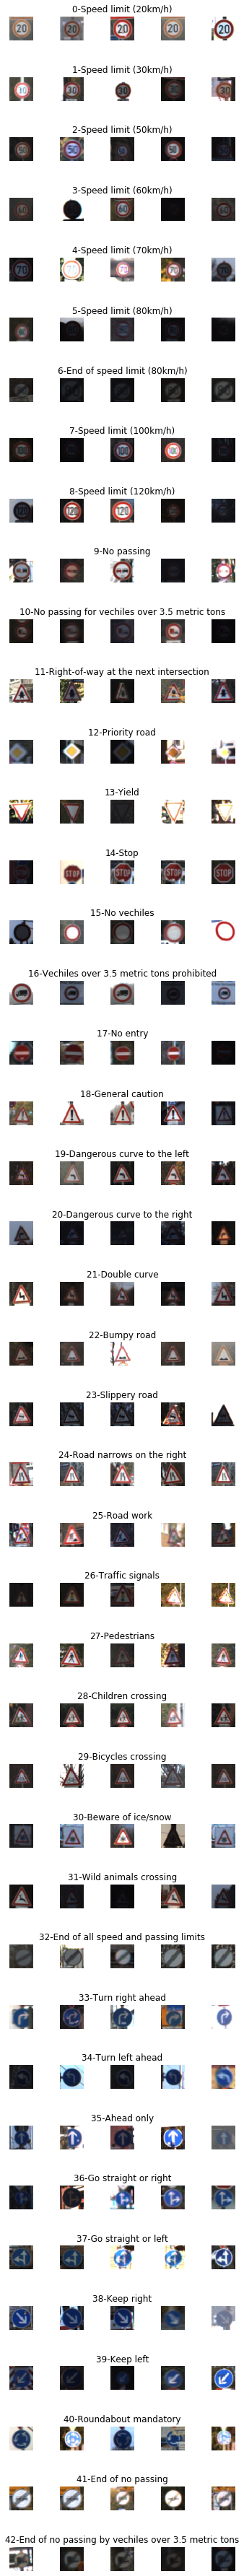

In [11]:
num_of_samples = []
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap = plt.get_cmap('gray'))
    axs[j][i].axis("off")

    if i == 2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


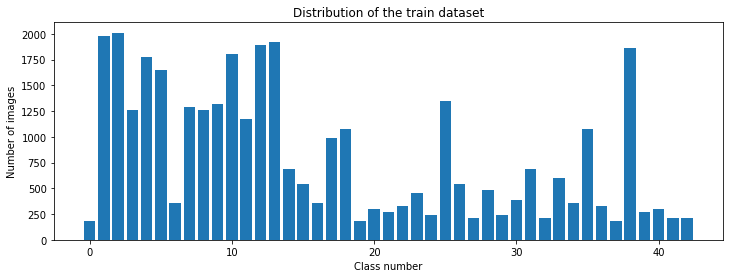

In [12]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


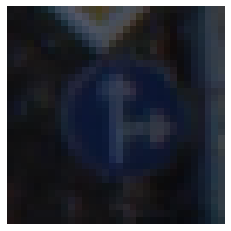

In [13]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


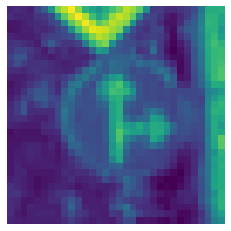

In [14]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


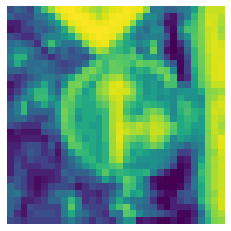

In [15]:
def equalize(img):
  img = cv2.equalizeHist(img) # this will take image that is already grayscale processed
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img / 255
  return img 

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


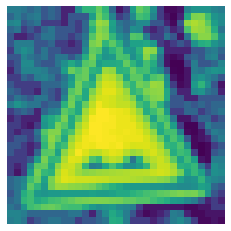

In [17]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [18]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


The last technique we are going to introduce is referred to as **'data augmentation'**, this is the process by which we create new data for our model to use during the training process. This is done by taking our existing datasets and transforming or altering the images in useful ways to create new images. For example, we can have a typical traffic sign image such as this stop sign image and now we can take this image and transform it to create a different image representing the same stop sign, an example of the transformation could be rotation or it could be something as simple as zooming entity image or it could even be a combination of both these transformations. these newly created images are referred to as augmented images because they essentially allow us to augment our dataset by adding new data to it. Now this process might initially appear to be redundant, a stop sign is so a stop sign at the end of the day, so why would our model benfit from looking at a rotated picture of the same stop sign or even zoomed in picture of the stop sign? well the answer to that would be variety , the reason is data augmentation technique is useful because it allows our model to look at each image in our dataset from a variety of different perspective. This allows it to extract relevant features more accurately and allows it to attain more feature related data from each training image. This is especially the case for our traffic sign datasets because we have a small dataset and a large number of classes. This means that certain classes have a very few proximately only 200 training images to wotk with. Now that you have gained a basic understanding of data aufementation and how it can benfit our traffic sign classification model let's put the technique to use by coding it. We are going to use the same code that we just wrote, we are just going to make some modifications to it.

The first step from Keras.preprocessing.image liberary we import the ImageDataGenerator.
The next step in the process is to make a call to the ImageDataGenerator class, this class will allow us to define the types of transformations we want to make to our data sets and it will also allow us to set range limits for just how extrem these transformations can get.
As expected this class takes in a variety of arguments each of which allows for unique transformations to our dataset. we are going to focus on the 5 following transformations, These 5 transformations will add suffiecient variety to dataset and will allow the training process to be much more effective:

1 - width_shift_range, this refer to a horizontal translation in the image which will cause our image to be off centered, this help our model adapt to test images that arenot necessaryily going to be centered. This range acn be defined in 2 ways:
if the range value is defined as a number between 0 and 1 then it referes to the fraction of the image that can be shifted, for example a value of 0.1 would simply imply that the maximum horizontal shift possibleis 10% of the width of the image, while if the range value is greater than 1 it refers to theshift and the number of pixels, so a value of 10 would mean that the maximumn horizontal shift possible is 10 pixels wide and we are going to leave this value as 0.1, 10% of the images wid
2 - height_shift_range, it is very similar to width_shit_range, the only difference being that it refers to a vertical translation within the image rather than the horizontal one. The range value is defined in much the same way and for that reason we will leave it at 0.1 as well.
3 - zoom_range,  it will either zoom out or into the image. The degree of zoom can be defined with a float value between 0 and 1, while the maximum outer zoom is defined by 1 minus the float value and the maximum inner zoom is defined by 1 plus the float value. We will use a float value of 0.2, which means that we can zoom as far as 0.8 and zoom in as close as 1.2
4 - shear_range, shear transformation. In plane geometry a shear mapping is a linear map that displaces each point in fixed direction by an amount proportional to its signed distance from aline that is parallel to that direction. It can be visualized here as you can see, shear is possible in both the x and the y direction which adds some variety to the transformation. This transformation is defined using shear intesnsity which simply refers to the magnitude of the shear ah]ngle in degrees. We only need a small magnitude of shear for it to be effective, so we will use a value of 0.1
5 - rottion_range, This transformation is a bit more intuitive and it simply rotates an image by a certain value of degrees. This value can be defined using an integer value. In our case we will use 10

Now we have effectively defined our image data generator and we have defined its capabilities, the transformations that it can apply and the range of these transformations have been defined. Wecan now store this inside of a variable which we will call it 'datagen'. 

Next step of the data augmentation process, we can now fit this image data generator to our actual training data and we do this by calling datagen.fit(). This fit is important because it allows the image generator to calculate any statistic required to actually perform these transformations to your datasets. The interesting thing to note about the image data generator is that it is an iterator which only returns batches of transformed images when requested. This means that the data generator does not perform operations on all the images in your data sets as that would be very memory intensuve due to all the new images being created. Instead it only creates these new augmented images in real time what are requested, this reduces overall memory requirements, however it leads additional time cost during the training process as that is when the data will be created.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10)
datagen.fit(X_train)

Call our image data generator to create some new images. The method for requesting our generator to create new images is by using the data edge in datagen.flow statementd. datagen referring to our image generator and the flow is requesting to our image generator and the flow is requesting the image generated for images and so into that we input our X_train datasets and introspective y_train labels as this is the data that our image generator will use for creating new images and finally we can find a batch size which were refered the amount of images created every time, this data flow that iterator is called, for sake of demonstration we will choose an arbitrary about size around the ballpark of 20.
We have now successfully created an iterator which stores a batch of 20 images along with their respective labels, and we can store this in a variable called 'batches'.

In order to get a good visual of these augmented images we are going to plot them, however before we do that we need to take our batches iterator containing data about our newly created images and store the data inside of an X_batch and respective y_batch array. This is done using the built in python command 'next' and the 'next' function simply calls an iterator item and retrieves the next item for it. As we defined our iterator to create a batch size of 20 we get 20 new images each time the next function is called on the iterator. So lets call our iterator object batches to get our new batch of 20 images. Lets plot these images, we will get an idea of what our transformed images look like and the added variety that this image generator adds to our dataset. we can use the plt.subplots function to diaply multiple plots.

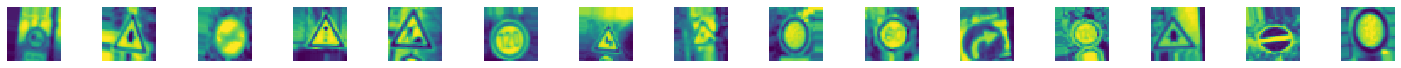

In [20]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

Above code after ran, it displays our brand new 15 images that our image generator created. they have been augmented in different ways to help add variety to our datasets. As you can see these images do not look like our typical traffic sign, that is some have been zoomed in or out while others have been rotated shearded or shifted. for the most part many of these images have been transformed in more than one way. This means that our data augmentation process was indeed effective and will be a useful training tool for our model.
Solets integrate the state a generator within our model.

In [0]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5),  activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.5))
  #
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  # Complie the model
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [23]:
model = modified_model()
print(model.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0        

Here we are going to use the fit_generator statement, which it is capable of running our image generator in parallel with the model training process. the statement will train our model using the augmented data produced by our generator.
The first argument for the fit_genetor is your traing data, in our case we are going to use the familiar datagen.flow function to create augmented data for our model, like before we use our X_train and y_train datasets as the reference for our newly created data and we are then going to declare a batch_size equal to 50 which means that our image generator will create a batch of 50 images at a time for our model to use. our next argument to fit_geneator will define the steps_per_epoch this parameter essentialy refers to the amount of batches our image generator generates per epoch, in a way this allows us to determine the size of our augmented datasets which is a big bonus of using an image generator with previous experience, our iminist dataset has had 60000 images however considering that our traffic signs dataset has 43 classes to classify we will need a larger pool of images to train on for effective training , so lets try this with a dataset of 100000 images and about size of 50 we will need a step size of 2000, 2000 batches  * 50 images per batch = 100000 images per epoch. we will once again run our model for 10 epochs. and we use the same validation data in the form of (X_val, y_val), an finally we finish this statement by setting our data shuffle to 1 to ensure that proper shuffling occurs and we are now ready to run our fit_generator and train our data...


After run done, as you can see our validation acuracy converges to above 99%, a significanr improvement over our previous model which did not use the image generator in plotting the loss inaccuracy plots shows there is a larger gap between our training loss accuracy and our validation loss and accouracy. This might be the result of having too many drop out layers in our model.
So lets try removing a dropout layer and re-training our model....

Our plots now our modification was pretty effective, now we have a much smallar gap between our training loss and training accuracy as well as our validation loss and accuracy respoectively. and this demonstrates consistency in our training and implies a better trained model and we now finish our model training with a validation accuracy of over 99% and a training accuracy ~98%, which is higher than what our model could provide without the fit_generator, and now evaluating the accuracy of the model on our test data, this also gives a pretty high relative accuracy of 97% almost 98% 

This is all very good to see and shows that our augmentation technique was effective 

In [24]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val, y_val), shuffle=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/10





2000/2000 [==============================] - 1052s 526ms/step - loss: 0.8990 - acc: 0.7349 - val_loss: 0.0805 - val_acc: 0.9791
Epoch 2/10
2000/2000 [==============================] - 1061s 531ms/step - loss: 0.2104 - acc: 0.9346 - val_loss: 0.0750 - val_acc: 0.9787
Epoch 3/10
2000/2000 [==============================] - 1059s 530ms/step - loss: 0.1452 - acc: 0.9552 - val_loss: 0.0535 - val_acc: 0.9830
Epoch 4/10
2000/2000 [==============================] - 1053s 526ms/step - loss: 0.1147 - acc: 0.9644 - val_loss: 0.0522 - val_acc: 0.9837
Epoch 5/10
2000/2000 [==============================] - 1071s 535ms/step - loss: 0.0945 - acc: 0.9710 - val_loss: 0.0479 - val_acc: 0.9841
Epoch 6/10
2000/2000 [==============================] - 1062s 531ms/step - loss: 0.0812 - acc: 0.9754 - val_loss: 0.0790 - val_acc: 0.9850
Epoch 7/10
2000/2000 [==============================] - 1066s 53

Text(0.5, 0, 'epoch')

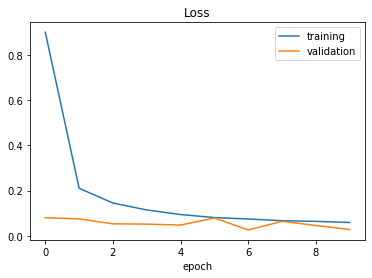

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

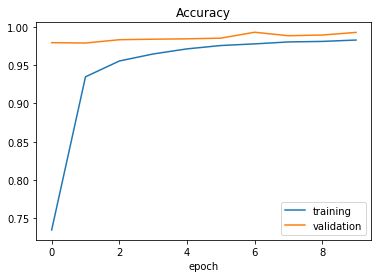

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [27]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

Test Score:  0.12777326586610055
Test Accuracy:  0.9756927949515771


Now we can put our network to real test by evaluating it on a real images off the internet. We will try a variety of images and see if our network can classify them correctly.
We will require the following image links in order to test your neural network:
•	https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg
label 1
•	https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg
lable 34
•	https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg
label 23
•	https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg 
label 13
•	https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg
label 29


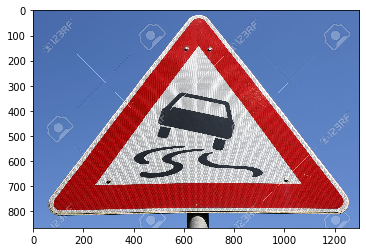

In [32]:
import requests
from PIL import Image
# url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
# url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
# url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

We will preprocessed the image the same way we preprocessed all of our  other images will. The only difference here from imnest how we did it in imnest is that instead of resizing it to a 28x28 we are resizing it to be 32x32 since we trained our NN on 32x32 images, so it is only fitting that we test our own NN on images of the same size. We still need to preprocess the test image the same way we preprocessed all our other images to ensure consistency. Thus calling the previously defined preprocessing function and we still need to reshape the image to have the appropriate depth before being fed into the NN. And reshaping image to have the appropriate depth and to actually feed the image into a NN. We have already made use of model.predict class, we simply predict the class to which our image most likely belongs.

(32, 32)


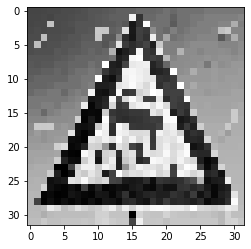

In [33]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
img = img.reshape(1, 32, 32, 1)

In [35]:
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [23]


We start by tesing the image of a speed limitsign which limits the max speed of 30 km per hour which means that it belongs to the class labeled one.
It seems that our model was successful in classifying this random image.

After running all the sample image, our model is not performing up to standard despite interducing modifications to our our model, we have still not hit a high accuracy for effective traffic on classification. This is the result of a more complex dataset. and inorder to take our models performance to the next level we are going to introduce one more technique for improving the model training process.

The last technique we are going to introduce is referred to as **'data augmentation'**, this is the process by which we create new data for our model to use during the training process. This is done by taking our existing datasets and transforming or altering the images in useful ways to create new images. For example, we can have a typical traffic sign image such as this stop sign image and now we can take this image and transform it to create a different image representing the same stop sign, an example of the transformation could be rotation or it could be something as simple as zooming entity image or it could even be a combination of both these transformations. these newly created images are referred to as augmented images because they essentially allow us to augment our dataset by adding new data to it. Now this process might initially appear to be redundant, a stop sign is so a stop sign at the end of the day, so why would our model benfit from looking at a rotated picture of the same stop sign or even zoomed in picture of the stop sign? well the answer to that would be variety , the reason is data augmentation technique is useful because it allows our model to look at each image in our dataset from a variety of different perspective. This allows it to extract relevant features more accurately and allows it to attain more feature related data from each training image. This is especially the case for our traffic sign datasets because we have a small dataset and a large number of classes. This means that certain classes have a very few proximately only 200 training images to wotk with. Now that you have gained a basic understanding of data aufementation and how it can benfit our traffic sign classification model let's put the technique to use by coding it. We are going to use the same code that we just wrote, we are just going to make some modifications to it.